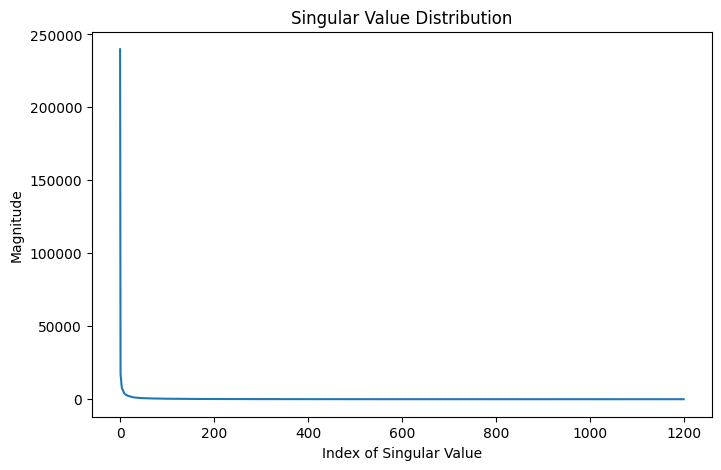

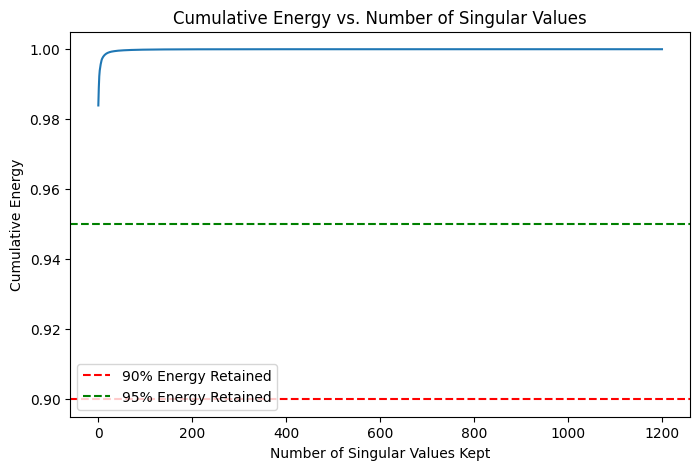

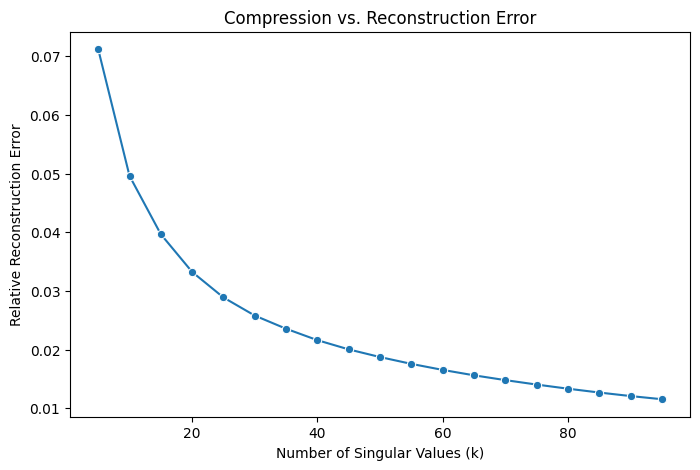

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd

class SVDCompressor:
    def __init__(self, image_path):
        """Loads an image, converts to grayscale, and computes its SVD."""
        self.image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if self.image is None:
            raise ValueError("Failed to load image. Check the file path.")

        self.U, self.S, self.Vt = svd(self.image, full_matrices=False)

    def compress(self, k):
        """Reconstructs the image using only the top-k singular values."""
        return self.U[:, :k] @ np.diag(self.S[:k]) @ self.Vt[:k, :]

    def save_compressed(self, k, output_path):
        """Compresses the image and saves it."""
        compressed_image = self.compress(k)
        compressed_image = np.clip(compressed_image, 0, 255).astype(np.uint8)
        cv2.imwrite(output_path, compressed_image)

class SVDVisualizer:
    def __init__(self, svd_compressor):
        """Takes an SVDCompressor object and initializes visualization tools."""
        self.image = svd_compressor.image
        self.S = svd_compressor.S
        self.U = svd_compressor.U
        self.Vt = svd_compressor.Vt
        self.total_energy = np.sum(self.S**2)

    def plot_singular_values(self):
        """Plots the singular value distribution."""
        plt.figure(figsize=(8, 5))
        sns.lineplot(x=np.arange(len(self.S)), y=self.S)
        plt.title("Singular Value Distribution")
        plt.xlabel("Index of Singular Value")
        plt.ylabel("Magnitude")
        plt.savefig("singular_values.png", format="png", dpi=300) 
        plt.show()

    def plot_cumulative_energy(self):
        """Plots the cumulative energy retained by singular values."""
        cumulative_energy = np.cumsum(self.S**2) / self.total_energy
        plt.figure(figsize=(8, 5))
        sns.lineplot(x=np.arange(len(self.S)), y=cumulative_energy)
        plt.axhline(y=0.9, color="r", linestyle="--", label="90% Energy Retained")
        plt.axhline(y=0.95, color="g", linestyle="--", label="95% Energy Retained")
        plt.title("Cumulative Energy vs. Number of Singular Values")
        plt.xlabel("Number of Singular Values Kept")
        plt.ylabel("Cumulative Energy")
        plt.legend()
        plt.savefig("cumulaive_energy.png", format="png", dpi=300) 
        plt.show()

    def plot_compression_vs_error(self):
        """Plots the trade-off between compression level and reconstruction error."""
        ranks = np.arange(5, 100, 5)
        errors = []

        for k in ranks:
            approx_image = self.U[:, :k] @ np.diag(self.S[:k]) @ self.Vt[:k, :]
            error = np.linalg.norm(self.image - approx_image) / np.linalg.norm(self.image)
            errors.append(error)

        plt.figure(figsize=(8, 5))
        sns.lineplot(x=ranks, y=errors, marker="o")
        plt.title("Compression vs. Reconstruction Error")
        plt.xlabel("Number of Singular Values (k)")
        plt.ylabel("Relative Reconstruction Error")
        plt.savefig("compression_vs_error.png", format="png", dpi=300) 
        plt.show()

image_path = "data/cat.jpg"
output_path = "compressed_cat.jpg"

# 1. Compress Image
compressor = SVDCompressor(image_path)
compressor.save_compressed(k=50, output_path=output_path)

# 2. Visualize SVD Properties
visualizer = SVDVisualizer(compressor)
visualizer.plot_singular_values()
visualizer.plot_cumulative_energy()
visualizer.plot_compression_vs_error()
